# Clasificación de Texto con BERT y Hugging Face

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Ohtar10/icesi-nlp/blob/main/Sesion4/1-text-classification-with-hf.ipynb)

En este notebook implementaremos un clasificador de noticias en español utilizando transformers pero ya basandonos en un modelo pre-entrenado tipo Bidirectional Encoder Representation from Transformers o BERT por sus siglas y disponible en Hugging Face Hub. El propósito de esta tarea es aprender a utilizar modelos pre-entrenados que por si mismos, sería sumamente costoso entrenar desde cero, tanto por el poder de computo como la disponibilidad de datos de entrenamiento. Entonces gran parte de la labor ya ha sido realizada por nosotros. Nuestra tarea ahora es especializar el modelo en la tarea que tenemos a la mano.

En esta ocasión, vamos a apartarnos de Pytorch Lightning y harémos uso extensivo de la herramientas de Hugging Face, las cuales están especialmente desarrolladas para este tipo de tareas, incluyendo la interacción con modelos pre-entrenados.

#### Referencias
- Dataset: https://huggingface.co/datasets/MarcOrfilaCarreras/spanish-news
- [BETO: Spanish BERT](https://huggingface.co/dccuchile/bert-base-spanish-wwm-cased)
- [BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](http://arxiv.org/abs/1810.04805)
- [Natural Language Processing with Transformers: Building Language Applications With Hugging Face](https://www.amazon.com/Natural-Language-Processing-Transformers-Applications/dp/1098103246)
- [Hugging Face Transformers](https://huggingface.co/docs/transformers/v4.41.3/en/index)
- [Hugging Face Accelerate](https://huggingface.co/docs/accelerate/index)
- [Hugging Face Evaluate](https://huggingface.co/docs/evaluate/v0.4.0/en/index)
- [Hugging Face Datasets](https://huggingface.co/docs/datasets/v2.19.0/en/index)

## DATASET wikiANN (es)

#### **Columnas principales**

* `tokens`: Lista de palabras (ej. `["José", "Luis", "García"]`).
* `ner_tags`: Lista de enteros que representan etiquetas IOB.
* `langs`: Idioma por token (aquí siempre `"es"`).
* `spans`: Entidades completas (ej. `"PER: José Luis García"`).

#### **Formato de Etiquetas (IOB)**

El dataset usa un esquema IOB con 3 tipos de entidades: **Persona (PER)**, **Organización (ORG)** y **Lugar (LOC)**.

| ID | Tag   | Significado               |
| -- | ----- | ------------------------- |
| 0  | O     | Outside (ninguna entidad) |
| 1  | B-PER | Beginning of Person       |
| 2  | I-PER | Inside Person             |
| 3  | B-ORG | Beginning of Organization |
| 4  | I-ORG | Inside Organization       |
| 5  | B-LOC | Beginning of Location     |
| 6  | I-LOC | Inside Location           |

**Número de etiquetas (`num_labels`) = 7**

#### **Ejemplo de muestra**

```python
{
 'tokens': ['REDIRECCIÓN', 'José', 'Luis', 'García'],
 'ner_tags': [0, 1, 2, 2],
 'langs': ['es', 'es', 'es', 'es'],
 'spans': ['PER: José Luis García']
}
```

Interpretación:

```
'REDIRECCIÓN' → O
'José'        → B-PER
'Luis'        → I-PER
'García'      → I-PER
```

In [1]:
import pkg_resources
import warnings

warnings.filterwarnings('ignore')

installed_packages = [package.key for package in pkg_resources.working_set]
IN_COLAB = 'google-colab' in installed_packages

/tmp/ipykernel_701308/2396000874.py:1: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


In [ ]:
#!test '{IN_COLAB}' = 'True' && wget https://github.com/boterol/BERT-transfer-learning/blob/main/requirements.txt && pip install -r requirements.txt
!test '{IN_COLAB}' = 'True' && sudo apt-get update -y
!test '{IN_COLAB}' = 'True' && sudo apt-get install python3.10 python3.10-distutils python3.10-lib2to3 -y
!test '{IN_COLAB}' = 'True' && sudo update-alternatives --install /usr/local/bin/python python /usr/bin/python3.11 2
!test '{IN_COLAB}' = 'True' && sudo update-alternatives --install /usr/local/bin/python python /usr/bin/python3.10 1
!test '{IN_COLAB}' = 'True' && pip install lightning datasets 'transformers[torch]' sentence-transformers torchinfo evaluate

### Cargando el dataset
Este es un dataset pequeño de frases en idioma español con sus respectivas labels de los tipos de entidades. El dataset está disponible en el HuggingFace Hub y puede ser fácilmente descargado con la librería.

In [34]:
from datasets import load_dataset
import warnings
import os

warnings.filterwarnings("ignore")
dataset = load_dataset("wikiann", "es", split='train')
df = dataset.to_pandas()
df['text']=[" ".join(i['tokens']) for i in df]
df['text']=[" ".join(i) for i in df['tokens']]
df.pop('tokens')
df.head(50)

,ner_tags,langs,spans,text
0,"[0, 5, 6, 6, 6]","[es, es, es, es, es]",[LOC: Algarrobo ( Chile )],REDIRECCIÓN Algarrobo ( Chile )
1,"[1, 2, 2]","[es, es, es]",[PER: W. G. Sebald],W. G. Sebald
2,"[0, 0, 0, 0, 0, 0, 1, 2]","[es, es, es, es, es, es, es, es]",[PER: Tamás Faragó],' '' Entrenador / a '' Tamás Faragó
3,"[0, 3, 4, 4, 4, 4]","[es, es, es, es, es, es]",[ORG: Società Sportiva Virtus Lanciano 1924],REDIRECCIÓN Società Sportiva Virtus Lanciano 1924
4,"[3, 4, 4, 4]","[es, es, es, es]",[ORG: Houses of the Holy],Houses of the Holy
5,"[0, 5, 0, 0, 0]","[es, es, es, es, es]",[LOC: Luanda],** Luanda ( Embajada )
6,"[0, 1, 2, 2]","[es, es, es, es]",[PER: José Luis García],REDIRECCIÓN José Luis García
7,"[5, 6, 6, 0]","[es, es, es, es]",[LOC: Condado de Duplin],Condado de Duplin suroeste
8,"[0, 5, 6, 6, 6]","[es, es, es, es, es]",[LOC: São Pedro do Funchal],REDIRECCIÓN São Pedro do Funchal
9,"[0, 0, 5, 0, 0, 0, 0]","[es, es, es, es, es, es, es]",[LOC: Huelva],50px '' Huelva '' '146.173 hab .


En esta ocasión, vamos a explorar un poco más las características del dataset a manera ilustrativa.

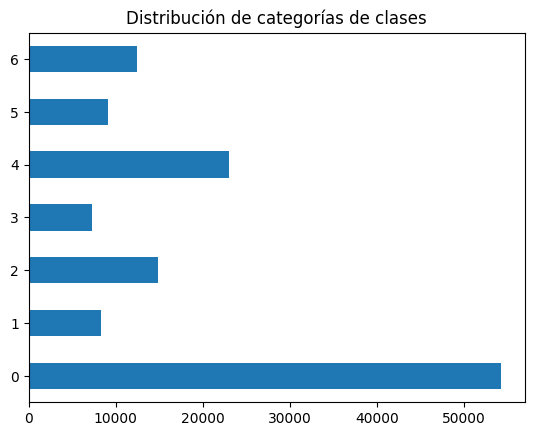

In [23]:
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter

df_cat=pd.DataFrame(df['ner_tags'])
all_cats=[]
for cat in df_cat['ner_tags']: 
    all_cats.extend(cat)

pd.Series(Counter(all_cats)).sort_index().plot.barh()
plt.title('Distribución de categorías de clases')
plt.show()

Observamos que es un dataset balanceado.

Ahora observemos la dispersión de las palabras por cada categoría.

In [38]:
# Calcula la longitud de cada texto en número de tokens (palabras)
text_lengths = df["text"].apply(lambda x: len(x.split()))

print(f"Texto más corto: {text_lengths.min()}")
print(f"Texto más largo: {text_lengths.max()}")
print(f"Longitud promedio: {text_lengths.mean():.2f}")
print(f"Mediana: {text_lengths.median()}")


Texto más corto: 3
Texto más largo: 64
Longitud promedio: 6.46
Mediana: 6.0


In [39]:
dataset.reset_format()

### Definiendo el Tokenizer

Como la idea en este notebook es la de re-utilizar modelos pre-entrenados, algo a tener en cuenta es que para que esto funcione correctamente, debemos **siempre** utilizar el mismo tokenizador que se usó para entrenar el modelo. Recordemos que el tokenizador asigna un código a cada token del vocabulario, y durante la creación de los embeddings, el modelo asume esto como entrada, por lo que su usamos otro tokenizador, el modelo va a ser incapaz de derivar las relaciones semánticas apropiadas.

Para esta tarea, haremos uso de un modelo BERT pre-entrenado en corpus del idioma español. El modelo puede ser encontrado [aquí](https://huggingface.co/dccuchile/bert-base-spanish-wwm-cased), es un modelo entrenado por el [Departamento de Ciencias de la Computación de la Universidad de Chile](https://www.dcc.uchile.cl), el cual según los autores, fue entrenado en un gran corpus de idioma español por lo que resulta un buen candidato para la tarea en cuestión.

In [41]:
from transformers import AutoTokenizer

model_ckpt = "dccuchile/bert-base-spanish-wwm-cased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

Ahora sometamos a prueba el tokenizador con la misma frase del notebook anterior.

In [42]:
tokenizer.pad_token = '[PAD]'
tokenizer("hola mundo!!", max_length=10, truncation=True, padding='max_length').tokens()

['[CLS]',
 'hola',
 'mundo',
 '!',
 '!',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

Algo interesante, este tokenizador, por lo menos para las palabras de esta frase de prueba, no separa en tokens distintos estas palabras, esto es justamente la razón por la cual no deberíamos usar un tokenizador diferente con un modelo pre-entrenado, habríamos obtenido tokens diferentes y el modelo no lograría interpretar la semantica como se espera.

Ahora, observemos su vocabulario.

In [43]:
tokenizer.vocab_size

31002

Tenemos $31002$ tokens, es una cantidad inferior que el modelo manual que intentamos en la lección anterior, pero lo suficientemente amplio para una tarea de NLP.

Ahora, observemos otros parámetros del tokenizador.

In [44]:
tokenizer.model_max_length

512

In [45]:
tokenizer.model_input_names

['input_ids', 'token_type_ids', 'attention_mask']

Primero, observamos que el tokenizador por defecto maneja un tamaño de secuencia de $512$, Que para nuestro dataset es bastante mas de lo necesario, por lo tanto, ninguna de las secuencias de entrada será truncada. Observando sus salidas, las cuales serán las entradas a nuestro modelo. Como ya debemos saber, `input_ids` son los indices de los tokens y `attention_mask` es la máscara de atención cuando tenemos tokens irrelevantes (como el padding) en la cadena.

## Usando un modelo BERT pre-entrenado sencillo

![](../assets/bert-architecture.png)
![](../assets/bert-tokenization.png)
Primero, vamos a probar con un modelo pre-entrenado sin mayor modificación a la capa de clasificación. Hugging Face ofrece una clase utilitaria para inicializar el modelo en modo de clasificación de tokens, lo cual hará que convenientemente tengamos una capa o cabeza de clasificación de tokens en entidades dentro del modelo, justo con la cantidad de clases que definamos.

Recordemos que el modelo y el tokenizador deben pertenecer al mismo "paquete", por lo que invocamos a `from_pretrained` con el mismo id que al tokenizer.


In [47]:
import torch
from torchinfo import summary
from transformers import AutoModelForTokenClassification

device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Device: {device}")
# Ejemplo de texto
inputs = tokenizer("Hola Mundo!!!", 
                   max_length=10, 
                   truncation=True, 
                   padding='max_length', 
                   return_tensors='pt')

print("Input Shapes & Types:")
print({k: (v.shape, v.dtype) for k, v in inputs.items()})

# Definición de etiquetas (ejemplo NER: O, PER, LOC, ORG)
label2id = {"O": 0, "B-PER": 1, "I-PER": 2, "B-ORG": 3, "I-ORG": 4, "B-LOC": 5, "I-LOC": 6}
id2label = {v: k for k, v in label2id.items()}

# Cargamos modelo para token classification (NER)
model = AutoModelForTokenClassification.from_pretrained(
    model_ckpt,
    num_labels=len(label2id),
    id2label=id2label,
    label2id=label2id
).to(device)

# Congelamos pesos del modelo base
for param in model.base_model.parameters():
    param.requires_grad = False

# torchinfo necesita los inputs esperados: input_ids y attention_mask
input_sizes = [inputs['input_ids'].shape, inputs['attention_mask'].shape]
input_types = [inputs['input_ids'].dtype, inputs['attention_mask'].dtype]

with torch.no_grad():
    print(summary(
        model, 
        input_size=input_sizes, 
        dtypes=input_types, 
        col_names=['input_size', 'output_size', 'num_params', 'trainable']
    ))


Device: cuda
Input Shapes & Types:
{'input_ids': (torch.Size([1, 10]), torch.int64), 'token_type_ids': (torch.Size([1, 10]), torch.int64), 'attention_mask': (torch.Size([1, 10]), torch.int64)}


Some weights of BertForTokenClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Layer (type:depth-idx)                                       Input Shape               Output Shape              Param #                   Trainable
BertForTokenClassification                                   [1, 10]                   [1, 10, 7]                --                        Partial
├─BertModel: 1-1                                             [1, 10]                   [1, 10, 768]              --                        False
│    └─BertEmbeddings: 2-1                                   --                        [1, 10, 768]              --                        False
│    │    └─Embedding: 3-1                                   [1, 10]                   [1, 10, 768]              (23,809,536)              False
│    │    └─Embedding: 3-2                                   [1, 10]                   [1, 10, 768]              (1,536)                   False
│    │    └─Embedding: 3-3                                   [1, 10]                   [1, 10, 768]              (393,216)  

Observamos que el modelo tiene una capa `BertModel` que corresponde al modelo pre-entrenado y finaliza con una capa lineal que sería nuestro clasificador, esta es una capa proporcionada para nosotros al momento de inicializar el modelo. Además, observamos que solamente la capa lineal que hemos especificado tiene parámetros entrenables. Entonces, a pesar de que el modelo en si tiene más de 100 millones de parámetros, solamente menos de 10 mil son entrenables.

Observemos todos los modulos registrados en el modelo:

In [48]:
modules = [m for m, _ in model.named_modules()]
modules

['',
 'bert',
 'bert.embeddings',
 'bert.embeddings.word_embeddings',
 'bert.embeddings.position_embeddings',
 'bert.embeddings.token_type_embeddings',
 'bert.embeddings.LayerNorm',
 'bert.embeddings.dropout',
 'bert.encoder',
 'bert.encoder.layer',
 'bert.encoder.layer.0',
 'bert.encoder.layer.0.attention',
 'bert.encoder.layer.0.attention.self',
 'bert.encoder.layer.0.attention.self.query',
 'bert.encoder.layer.0.attention.self.key',
 'bert.encoder.layer.0.attention.self.value',
 'bert.encoder.layer.0.attention.self.dropout',
 'bert.encoder.layer.0.attention.output',
 'bert.encoder.layer.0.attention.output.dense',
 'bert.encoder.layer.0.attention.output.LayerNorm',
 'bert.encoder.layer.0.attention.output.dropout',
 'bert.encoder.layer.0.intermediate',
 'bert.encoder.layer.0.intermediate.dense',
 'bert.encoder.layer.0.intermediate.intermediate_act_fn',
 'bert.encoder.layer.0.output',
 'bert.encoder.layer.0.output.dense',
 'bert.encoder.layer.0.output.LayerNorm',
 'bert.encoder.layer.0

Observamos que la capa final es efectivamente el clasificador. Ahora hagamos una prueba pasando un dummy input:

In [49]:
with torch.no_grad():
    inputs = {k: v.to(device) for k, v in inputs.items()}
    outputs = model(**inputs)
print({k: v.shape for k, v in outputs.items()})

{'logits': torch.Size([1, 10, 7])}


In [56]:
logits=outputs.logits
pred_ids = torch.argmax(logits, dim=-1) 
pred_ids

tensor([[3, 3, 3, 1, 1, 2, 1, 3, 2, 1]], device='cuda:0')

In [51]:
model.classifier

Linear(in_features=768, out_features=7, bias=True)

Observamos que tras invocar el modelo, en efecto, obtenemos una salida de 7 dimensiones x cada token, correspondientes al número de labels.

Ahora preparemos los datos para el entrenamiento.

Hugging Face Datasets convenientemente implementa una función para hacer el train-test split en nuestro dataset y automáticamente creará nuevas llaves en el mismo para diferenciarlo.

In [57]:
training_dataset = dataset.train_test_split(train_size=0.8)
validation_dataset = training_dataset['test'].train_test_split(train_size=0.5)

In [58]:
from datasets.dataset_dict import DatasetDict

new_dataset = DatasetDict({
    'train': training_dataset['train'],
    'val': validation_dataset['train'],
    'test': validation_dataset['test'],
})
new_dataset

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'spans'],
        num_rows: 16000
    })
    val: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'spans'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'spans'],
        num_rows: 2000
    })
})

Tenemos nuestros tres conjuntos, sin embargo, esto es la información cruda, debemos preparar los datos para el modelo, lo gual incluye tokenizar y convertir las categorías a ids. Preparamos entonces unas funciones utilitarias.

In [62]:
def preprocess_function(max_len):
    def _preprocess_function(examples):
        return tokenizer(examples['text'], max_length=max_len, truncation=True, padding='max_length')
    return _preprocess_function

def tokenize(max_len: int = 8):
    def _tokenize(batch):
        return tokenizer(batch['text'], max_length=max_len, truncation=True, padding='max_length')
    return _tokenize

'''def label_names_2_ids(batch):
    batch['label'] = label2id[batch['category']]
    return batch'''


"def label_names_2_ids(batch):\n    batch['label'] = label2id[batch['category']]\n    return batch"

Y procedemos a invocarlas. Nótese que para la tokenización, estamos forzando a que las cadenas sean de 512 tokens, según el análisis que hemos hecho anteriormente.

In [91]:
def preprocess_function(examples, max_len=512):
    input_ids = []
    attention_masks = []
    label_ids = []

    for tokens, ner_tags in zip(examples["tokens"], examples["ner_tags"]):
        # Convert tokens to IDs
        ids = tokenizer.convert_tokens_to_ids(tokens)

        # Truncate both ids and labels
        ids = ids[:max_len]
        labels = ner_tags[:max_len]

        # Pad input_ids
        padding_length = max_len - len(ids)
        ids = ids + [tokenizer.pad_token_id] * padding_length
        mask = [1] * len(tokens[:max_len]) + [0] * padding_length

        # Pad labels with -100 (so loss ignores them)
        labels = labels + [-100] * padding_length

        input_ids.append(ids)
        attention_masks.append(mask)
        label_ids.append(labels)

    return {
        "input_ids": input_ids,
        "attention_mask": attention_masks,
        "labels": label_ids
    }


In [92]:
tokenized_dataset = new_dataset.map(
    lambda batch: preprocess_function(batch, max_len=512),
    batched=True
)


Map: 100%|██████████| 2000/2000 [00:00<00:00, 7377.10 examples/s]


In [93]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'spans', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 16000
    })
    val: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'spans', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'spans', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 2000
    })
})

#### Entrenamiento

Ahora procederemos al entrenamiento. Aquí harémos uso de las API de HuggingFace directamente.


In [114]:
from transformers import Trainer, TrainingArguments
from typing import Dict, Any
import evaluate
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np



label_list = ['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC']  # <-- replace with your labels
id2label = {i: l for i, l in enumerate(label_list)}
label2id = {l: i for i, l in enumerate(label_list)}

def compute_metrics(pred):
    """
    Compute standard classification metrics (accuracy, precision, recall, f1).
    """
    predictions = np.argmax(pred.predictions, axis=-1)
    labels = pred.label_ids

    # Flatten predictions and labels, ignoring -100 (padding tokens)
    true_predictions = []
    true_labels = []
    for pred_seq, label_seq in zip(predictions, labels):
        for p, l in zip(pred_seq, label_seq):
            if l != -100:
                true_predictions.append(p)
                true_labels.append(l)

    acc = accuracy_score(true_labels, true_predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(
        true_labels, true_predictions, average="macro"
    )

    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

# Batch size depending on your environment
batch_size = 8
logging_steps = len(tokenized_dataset["train"]) // batch_size

# ✅ Training args
training_args = TrainingArguments(
    output_dir='./hf-ner',
    num_train_epochs=2,
    learning_rate=2e-5,
    per_device_eval_batch_size=batch_size,
    per_device_train_batch_size=batch_size,
    weight_decay=0.01,
    evaluation_strategy='epoch',   
    save_strategy='epoch',
    load_best_model_at_end=True,
    disable_tqdm=False,
    logging_steps=logging_steps,
    report_to='tensorboard'
)

# ✅ Trainer for NER
trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["val"],
    tokenizer=tokenizer
)


In [115]:
from transformers import Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np

# -----------------------------
# Metrics for token classification
# -----------------------------
def compute_metrics(pred):
    """
    Compute per-token classification metrics.
    Ignores labels set to -100 (padding tokens)
    """
    predictions = np.argmax(pred.predictions, axis=-1)
    labels = pred.label_ids

    true_preds = []
    true_labels = []

    for pred_seq, label_seq in zip(predictions, labels):
        for p, l in zip(pred_seq, label_seq):
            if l != -100:
                true_preds.append(p)
                true_labels.append(l)

    acc = accuracy_score(true_labels, true_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        true_labels, true_preds, average="macro"
    )

    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

# -----------------------------
# Training arguments
# -----------------------------
batch_size = 4  
logging_steps = len(tokenized_dataset['train']) // batch_size

training_args = TrainingArguments(
    output_dir='./hf-ner',
    num_train_epochs=2,
    learning_rate=5e-4,  
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    evaluation_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    logging_steps=logging_steps,
    report_to='tensorboard'
)

# -----------------------------
# Freeze BERT base
# -----------------------------
for param in model.base_model.parameters():
    param.requires_grad = False

# -----------------------------
# Trainer
# -----------------------------
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["val"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)


Con esto nos basta para ejecutar el entrenamiento:

In [116]:
%%time
trainer.train()

 50%|█████     | 4000/8000 [05:15<05:14, 12.73it/s]

{'loss': 0.9174, 'grad_norm': 5.982828140258789, 'learning_rate': 0.00025, 'epoch': 1.0}


 50%|█████     | 4000/8000 [05:52<05:14, 12.73it/s]

{'eval_loss': 0.773411750793457, 'eval_accuracy': 0.7358827179646292, 'eval_precision': 0.7049471897392444, 'eval_recall': 0.625534703329958, 'eval_f1': 0.6577347297658004, 'eval_runtime': 37.2435, 'eval_samples_per_second': 53.701, 'eval_steps_per_second': 13.425, 'epoch': 1.0}


100%|██████████| 8000/8000 [11:10<00:00, 12.56it/s]  

{'loss': 0.913, 'grad_norm': 4.355657577514648, 'learning_rate': 0.0, 'epoch': 2.0}


100%|██████████| 8000/8000 [11:48<00:00, 12.56it/s]

{'eval_loss': 0.7712481617927551, 'eval_accuracy': 0.7372789326714242, 'eval_precision': 0.7056923203862873, 'eval_recall': 0.628785570436496, 'eval_f1': 0.6603764036537869, 'eval_runtime': 37.3089, 'eval_samples_per_second': 53.607, 'eval_steps_per_second': 13.402, 'epoch': 2.0}


100%|██████████| 8000/8000 [11:48<00:00, 11.28it/s]

{'train_runtime': 708.9533, 'train_samples_per_second': 45.137, 'train_steps_per_second': 11.284, 'train_loss': 0.9152194213867187, 'epoch': 2.0}
CPU times: user 11min 29s, sys: 21.3 s, total: 11min 50s
Wall time: 11min 49s


TrainOutput(global_step=8000, training_loss=0.9152194213867187, metrics={'train_runtime': 708.9533, 'train_samples_per_second': 45.137, 'train_steps_per_second': 11.284, 'total_flos': 8361874194432000.0, 'train_loss': 0.9152194213867187, 'epoch': 2.0})

Algo importante a resaltar es que fueron necesarias solo 2 iteraciones para alcanzar un tasa de correctitud $\approx 73%$, algo que con el modelo de transformers crudo nos costó muchas más iteraciones. Esto demuestra la importancia de partir de modelos pre-entrenados para este tipo de tareas.

Una ventaja adicional de Hugging Face transformers, es que publica automáticamente el progreso del entrenamiento a tensorboard, en el directorio que hemos especificado. Observemos entonces el proceso de entrenamiento:

In [118]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [103]:
%tensorboard --logdir hf/runs

Y ahora evaluemos el modelo en el conjunto de prueba:

In [119]:
model.eval()
trainer.evaluate(tokenized_dataset['test'])

100%|██████████| 500/500 [00:36<00:00, 13.61it/s]


{'eval_loss': 0.779617190361023,
 'eval_accuracy': 0.7317828226702652,
 'eval_precision': 0.7044710031223422,
 'eval_recall': 0.6271342428179869,
 'eval_f1': 0.6573209722608893,
 'eval_runtime': 36.8215,
 'eval_samples_per_second': 54.316,
 'eval_steps_per_second': 13.579,
 'epoch': 2.0}

Hemos alcanzado una correctitud del $\approx 80\%$, lo cual, nuevamente, en comparación con el modelo de transformers crudo nos costó muchisimo más lograr.

### Haciendo uso del modelo
Ahora, hagamos predicciónes con el modelo y observemos los resultados.

In [120]:
predictions = trainer.predict(tokenized_dataset['test'])
predictions

100%|██████████| 500/500 [00:36<00:00, 13.55it/s]


PredictionOutput(predictions=array([[[ 3.698278  ,  2.1999195 , -2.791962  , ..., -4.5042505 ,
          0.09645343, -5.8428087 ],
        [ 0.93821156,  0.7717347 ,  0.29448378, ..., -2.2272525 ,
         -1.4286265 , -2.9465032 ],
        [ 0.34353563, -0.11507095,  0.977844  , ..., -1.5054938 ,
         -2.284584  , -2.280034  ],
        ...,
        [ 2.7984204 ,  1.460154  , -0.8538184 , ..., -2.759731  ,
         -0.30901828, -3.9364414 ],
        [ 2.5177102 ,  1.5391496 , -0.9198532 , ..., -2.706764  ,
         -0.34798068, -3.7475448 ],
        [ 2.3703907 ,  0.9172478 , -0.58972645, ..., -2.330913  ,
         -0.652017  , -3.5605698 ]],

       [[ 2.1262493 , -2.197167  , -5.798137  , ..., -1.5983897 ,
          1.9094486 , -2.2015743 ],
        [ 0.08091775, -3.7032917 , -3.5509198 , ...,  0.4340486 ,
          1.1929848 ,  0.06223092],
        [ 1.1157013 , -7.333284  , -2.683442  , ...,  2.8952367 ,
         -3.601121  ,  1.4687955 ],
        ...,
        [ 1.7722653 , -2.

In [121]:
import numpy as np

# predictions.predictions: shape (num_batches, seq_len, num_labels)
predicted_label_ids = np.argmax(predictions.predictions, axis=-1)  # shape (num_batches, seq_len)

# Flatten para iterar sobre cada ejemplo
all_preds = []
all_labels = []

for pred_seq, label_seq in zip(predicted_label_ids, predictions.label_ids):
    # filtra los tokens con label = -100
    filtered_pred = [id2label[p] for p, l in zip(pred_seq, label_seq) if l != -100]
    filtered_label = [id2label[l] for l in label_seq if l != -100]
    
    all_preds.append(filtered_pred)
    all_labels.append(filtered_label)



test_set = tokenized_dataset['test'].remove_columns(['labels'])  # opcional
test_set = test_set.add_column("predictions", all_preds)
test_set = test_set.add_column("true_labels", all_labels)



In [123]:
n_examples = 10  

for i in range(n_examples):
    print(f"\n=== Example {i} ===")
    tokens = test_set[i]['input_ids']
    true_labels = test_set[i]['true_labels']
    pred_labels = test_set[i]['predictions']

    for token_id, t_label, p_label in zip(tokens, true_labels, pred_labels):
        token_str = tokenizer.decode([token_id])
        print(f"{token_str:15}  True: {t_label:10}  Pred: {p_label:10}")



=== Example 0 ===
[UNK]            True: O           Pred: O         
[UNK]            True: B-PER       Pred: O         
[UNK]            True: I-PER       Pred: I-PER     
[UNK]            True: I-PER       Pred: I-PER     

=== Example 1 ===
[UNK]            True: B-ORG       Pred: O         
Avenida          True: I-ORG       Pred: B-ORG     
(                True: I-ORG       Pred: I-ORG     
línea            True: I-ORG       Pred: I-ORG     
[UNK]            True: I-ORG       Pred: I-ORG     
End              True: I-ORG       Pred: I-ORG     
)                True: I-ORG       Pred: I-ORG     

=== Example 2 ===
[UNK]            True: B-ORG       Pred: O         
[UNK]            True: I-ORG       Pred: I-PER     
[UNK]            True: I-ORG       Pred: I-PER     

=== Example 3 ===
[UNK]            True: B-LOC       Pred: B-LOC     
Point            True: I-LOC       Pred: B-LOC     
(                True: I-LOC       Pred: I-LOC     
[UNK]            True: I-LOC       Pred:

Los errores parece que son en su  mayoria debido a un token desconocido, perjudicando asi en los resultados. Sin embargo, con todo y estos [UNK], el modelo se comporta bastante bien con 2 epocas.

## Usando una capa más especializada como clasificador

Quizás podemos hacerlo mejor, hemos observado que por defecto, cuando cargamos la clase, Hugging Face nos da un clasificador muy simple, solo una capa lineal. Pero podemos utilizar un clasificador más complejo que definamos nosotros. Esta técnica seguiría utilizando el resto del modelo como featurizer, pero ahora añadimos complejidad a la capa de clasificación en búsqueda de una mejor calidad en los resutlados.

Entonces, volvemos a cargar el modelo tal como hemos hecho antes:

In [126]:
import torch
from torchinfo import summary
from transformers import AutoModelForTokenClassification

device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Device: {device}")
# Ejemplo de texto
inputs = tokenizer("Hola Mundo!!!", 
                   max_length=10, 
                   truncation=True, 
                   padding='max_length', 
                   return_tensors='pt')

print("Input Shapes & Types:")
print({k: (v.shape, v.dtype) for k, v in inputs.items()})

# Definición de etiquetas (ejemplo NER: O, PER, LOC, ORG)
label2id = {"O": 0, "B-PER": 1, "I-PER": 2, "B-ORG": 3, "I-ORG": 4, "B-LOC": 5, "I-LOC": 6}
id2label = {v: k for k, v in label2id.items()}

# Cargamos modelo para token classification (NER)
model = AutoModelForTokenClassification.from_pretrained(
    model_ckpt,
    num_labels=len(label2id),
    id2label=id2label,
    label2id=label2id
).to(device)

# Congelamos pesos del modelo base
for param in model.base_model.parameters():
    param.requires_grad = False

# torchinfo necesita los inputs esperados: input_ids y attention_mask
input_sizes = [inputs['input_ids'].shape, inputs['attention_mask'].shape]
input_types = [inputs['input_ids'].dtype, inputs['attention_mask'].dtype]

with torch.no_grad():
    print(summary(
        model, 
        input_size=input_sizes, 
        dtypes=input_types, 
        col_names=['input_size', 'output_size', 'num_params', 'trainable']
    ))

Device: cuda
Input Shapes & Types:
{'input_ids': (torch.Size([1, 10]), torch.int64), 'token_type_ids': (torch.Size([1, 10]), torch.int64), 'attention_mask': (torch.Size([1, 10]), torch.int64)}


Some weights of BertForTokenClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Layer (type:depth-idx)                                       Input Shape               Output Shape              Param #                   Trainable
BertForTokenClassification                                   [1, 10]                   [1, 10, 7]                --                        Partial
├─BertModel: 1-1                                             [1, 10]                   [1, 10, 768]              --                        False
│    └─BertEmbeddings: 2-1                                   --                        [1, 10, 768]              --                        False
│    │    └─Embedding: 3-1                                   [1, 10]                   [1, 10, 768]              (23,809,536)              False
│    │    └─Embedding: 3-2                                   [1, 10]                   [1, 10, 768]              (1,536)                   False
│    │    └─Embedding: 3-3                                   [1, 10]                   [1, 10, 768]              (393,216)  

In [127]:
model.classifier

Linear(in_features=768, out_features=7, bias=True)

### Definimos un clasificador propio

Podemos definir cualquier tipo de clasificador que se nos ocurra, siempre que se ajuste a las entradas y salidas del clasificador existente. Vamos a utilizar por ejemplo la misma capa lineal que definimos en el notebook anterior:

In [128]:
import torch.nn as nn


classifier = nn.Sequential(
    nn.Linear(768, 512),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(256, 7),
    nn.LogSoftmax(dim=1)
)

# simplemente reemplazamos el clasificador existente por el nuestro:
model.classifier = classifier
with torch.no_grad():
    print(summary(model, input_size=input_sizes, dtypes=input_types, col_names=['input_size', 'output_size', 'num_params', 'trainable']))

Layer (type:depth-idx)                                       Input Shape               Output Shape              Param #                   Trainable
BertForTokenClassification                                   [1, 10]                   [1, 10, 7]                --                        Partial
├─BertModel: 1-1                                             [1, 10]                   [1, 10, 768]              --                        False
│    └─BertEmbeddings: 2-1                                   --                        [1, 10, 768]              --                        False
│    │    └─Embedding: 3-1                                   [1, 10]                   [1, 10, 768]              (23,809,536)              False
│    │    └─Embedding: 3-2                                   [1, 10]                   [1, 10, 768]              (1,536)                   False
│    │    └─Embedding: 3-3                                   [1, 10]                   [1, 10, 768]              (393,216)  

In [ ]:
model.classifier

Sequential(
  (0): Linear(in_features=768, out_features=512, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=512, out_features=256, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.2, inplace=False)
  (6): Linear(in_features=256, out_features=7, bias=True)
  (7): LogSoftmax(dim=1)
)

Observamos que nuestro modelo ya tiene más parámetros para entrenar, producto de nuestro nuevo clasificador.

Procedemos a definir nuevamente el entrenador.

In [130]:
trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['val'],
    tokenizer=tokenizer
)

Y a entrenar el modelo

In [131]:
%%time

trainer.train()

 50%|█████     | 4000/8000 [05:18<05:18, 12.57it/s]

{'loss': 0.8916, 'grad_norm': 8.400601387023926, 'learning_rate': 0.00025, 'epoch': 1.0}


 50%|█████     | 4000/8000 [05:55<05:18, 12.57it/s]

{'eval_loss': 0.6460847854614258, 'eval_accuracy': 0.7733478125969594, 'eval_precision': 0.7318793196021698, 'eval_recall': 0.6866983783498932, 'eval_f1': 0.7047237135245478, 'eval_runtime': 37.4409, 'eval_samples_per_second': 53.417, 'eval_steps_per_second': 13.354, 'epoch': 1.0}


100%|██████████| 8000/8000 [11:16<00:00, 12.50it/s]  

{'loss': 0.7268, 'grad_norm': 2.5237667560577393, 'learning_rate': 0.0, 'epoch': 2.0}


100%|██████████| 8000/8000 [11:54<00:00, 12.50it/s]

{'eval_loss': 0.6080610156059265, 'eval_accuracy': 0.7894042817251008, 'eval_precision': 0.7490576400906157, 'eval_recall': 0.7025945848846192, 'eval_f1': 0.7224106121120986, 'eval_runtime': 37.4909, 'eval_samples_per_second': 53.346, 'eval_steps_per_second': 13.337, 'epoch': 2.0}


100%|██████████| 8000/8000 [11:55<00:00, 11.19it/s]

{'train_runtime': 715.1473, 'train_samples_per_second': 44.746, 'train_steps_per_second': 11.187, 'train_loss': 0.8092391357421875, 'epoch': 2.0}
CPU times: user 11min 42s, sys: 14.6 s, total: 11min 57s
Wall time: 11min 55s


TrainOutput(global_step=8000, training_loss=0.8092391357421875, metrics={'train_runtime': 715.1473, 'train_samples_per_second': 44.746, 'train_steps_per_second': 11.187, 'total_flos': 8413136977920000.0, 'train_loss': 0.8092391357421875, 'epoch': 2.0})

Y evaluamos el resultado:

In [132]:
model.eval()
trainer.evaluate(tokenized_dataset['test'])

100%|██████████| 500/500 [00:36<00:00, 13.53it/s]


{'eval_loss': 0.6205454468727112,
 'eval_accuracy': 0.7798063184632481,
 'eval_precision': 0.7446983891190077,
 'eval_recall': 0.6926790751344455,
 'eval_f1': 0.7129742186133446,
 'eval_runtime': 37.0318,
 'eval_samples_per_second': 54.008,
 'eval_steps_per_second': 13.502,
 'epoch': 2.0}

Hemos obtenido una ligera mejora en nuestro modelo, lo cual sugiere que nuestro clasificador más complejo contribuye a una mayor calidad de los resultados.

## Fine Tuning con BERT

Para terminar, ahora harémos fine tuning, es decir, vamos a dejar libres todas las capas del modelo base para que todas calculen gradiente y entrenen sobre nuestra tarea específica.

En este caso entonces no necesitamos modificar nada del modelo original, podemos instanciarlo y proceder directamente al entrenamiento:

In [133]:
import torch
from torchinfo import summary
from transformers import AutoModelForTokenClassification

device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Device: {device}")
# Ejemplo de texto
inputs = tokenizer("Hola Mundo!!!", 
                   max_length=10, 
                   truncation=True, 
                   padding='max_length', 
                   return_tensors='pt')

print("Input Shapes & Types:")
print({k: (v.shape, v.dtype) for k, v in inputs.items()})

# Definición de etiquetas (ejemplo NER: O, PER, LOC, ORG)
label2id = {"O": 0, "B-PER": 1, "I-PER": 2, "B-ORG": 3, "I-ORG": 4, "B-LOC": 5, "I-LOC": 6}
id2label = {v: k for k, v in label2id.items()}

# Cargamos modelo para token classification (NER)
model = AutoModelForTokenClassification.from_pretrained(
    model_ckpt,
    num_labels=len(label2id),
    id2label=id2label,
    label2id=label2id
).to(device)

Device: cuda
Input Shapes & Types:
{'input_ids': (torch.Size([1, 10]), torch.int64), 'token_type_ids': (torch.Size([1, 10]), torch.int64), 'attention_mask': (torch.Size([1, 10]), torch.int64)}


Some weights of BertForTokenClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [137]:
training_args = TrainingArguments(
    output_dir='./hf-ner',
    num_train_epochs=1, #este lo puse a 1 epoch porque me esta cogiendo la tarde para entregar 
    learning_rate=2e-5,  
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    evaluation_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    logging_steps=logging_steps,
    report_to='tensorboard'
)

trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['val'],
    tokenizer=tokenizer
)

In [138]:
%%time
trainer.train()

100%|██████████| 4000/4000 [16:25<00:00,  4.02it/s]

{'loss': 1.7008, 'grad_norm': 4.4914422035217285, 'learning_rate': 0.0, 'epoch': 1.0}



100%|██████████| 4000/4000 [17:01<00:00,  4.02it/s]

{'eval_loss': 1.7018404006958008, 'eval_accuracy': 0.42243251628917156, 'eval_precision': 0.06034750232702451, 'eval_recall': 0.14285714285714285, 'eval_f1': 0.08485112880357727, 'eval_runtime': 36.406, 'eval_samples_per_second': 54.936, 'eval_steps_per_second': 13.734, 'epoch': 1.0}


100%|██████████| 4000/4000 [17:03<00:00,  3.91it/s]

{'train_runtime': 1023.6193, 'train_samples_per_second': 15.631, 'train_steps_per_second': 3.908, 'train_loss': 1.7007921142578124, 'epoch': 1.0}
CPU times: user 17min, sys: 4.98 s, total: 17min 5s
Wall time: 17min 4s


TrainOutput(global_step=4000, training_loss=1.7007921142578124, metrics={'train_runtime': 1023.6193, 'train_samples_per_second': 15.631, 'train_steps_per_second': 3.908, 'total_flos': 4180937097216000.0, 'train_loss': 1.7007921142578124, 'epoch': 1.0})

In [139]:
model.eval()
trainer.evaluate(tokenized_dataset['test'])

100%|██████████| 500/500 [00:35<00:00, 13.97it/s]


{'eval_loss': 1.7228543758392334,
 'eval_accuracy': 0.40657247182092393,
 'eval_precision': 0.05808178168870342,
 'eval_recall': 0.14285714285714285,
 'eval_f1': 0.08258626249596904,
 'eval_runtime': 35.865,
 'eval_samples_per_second': 55.765,
 'eval_steps_per_second': 13.941,
 'epoch': 1.0}

En mi caso las metricas estan bastante bajas luego de hacer fine-tunning. Es cierto que hubiera siedo bien probar con mas epocas y de pronto un learning rate mas grande.  

Feature extraction con BERT: Aunque solo entrenamos la capa superior sobre las representaciones preentrenadas de BERT, logramos un punto de partida sólido para NER. Con más epochs probablemente mejoraríamos el rendimiento, pero incluso así la estrategia permite entrenar rápido y evita sobreajuste.

Fine-tuning: Entrenar todas las capas de BERT permitiría que el modelo se adapte mejor a nuestro dataset específico. Con 1 época las métricas fueron desastrosas, cosa que no se por que otro factor pueda ser usando exactamente las mismas configuraciones que antes, exceptio por el learning rate que probe en rango de e-5 y e-4 sin cambios en los resultados.